In [1]:
from PIL import Image
import matplotlib.pyplot as plt
import torch
import numpy as np
%config InlineBackend.figure_format = 'retina'
import sys
sys.path.insert(1, '/home/acuzum/samproject/gen-attack/gen_attack/src/benchmarking/')
from visualize import Visualize

In [3]:
from transformers import DetrForObjectDetection , DetrImageProcessor
device = "cuda" if torch.cuda.is_available() else "cpu"

model = DetrForObjectDetection.from_pretrained("facebook/detr-resnet-50").to(device)
processor = DetrImageProcessor.from_pretrained("facebook/detr-resnet-50")



Some weights of the model checkpoint at facebook/detr-resnet-50 were not used when initializing DetrForObjectDetection: ['model.backbone.conv_encoder.model.layer1.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer2.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer3.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer4.0.downsample.1.num_batches_tracked']
- This IS expected if you are initializing DetrForObjectDetection from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DetrForObjectDetection from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [4]:
from PIL import Image
image = Image.open("../examp.png")

annotations = [
    {
    "image_id" : 0,
    "annotations" : [{"id": 0, 
                     "image_id" : 0,
                     "category_id" : 71,
                     "segmentation" : None,
                     "area" : None, 
                     "bbox": [64,97,445,242],
                     "iscrowd" : 0},
                    ]
    }
]

In [5]:
inputs = processor.preprocess(image,annotations, return_tensors="pt")
labels = [{k: v.to(device) for k, v in inputs["labels"][0].items()}]
pixel_values = inputs["pixel_values"].to(device)
pixel_values.requires_grad = True
pixel_mask = inputs["pixel_mask"].to(device)


The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.


In [6]:
outputs = model(pixel_values, pixel_mask, labels=labels)
model.zero_grad()
outputs.loss.backward()

# Inference without Attack

In [7]:
target_sizes = torch.tensor([image.size[::-1]])
results = processor.post_process_object_detection(outputs, threshold=0.9, target_sizes=target_sizes)[
    0
]

for score, label, box in zip(results["scores"], results["labels"], results["boxes"]):
    box = [round(i, 2) for i in box.tolist()]
    print(
        f"Detected {model.config.id2label[label.item()]} with confidence "
        f"{round(score.item(), 3)} at location {box}"
    )

not_pertrubed_labels = results["labels"].tolist()
not_pertrubed_labels = [model.config.id2label[i] for i in not_pertrubed_labels]
not_pertrubed_scores = results["scores"].tolist()
not_pertrubed_bbox = results["boxes"].tolist()

Detected bench with confidence 0.999 at location [61.37, 98.49, 511.75, 343.61]


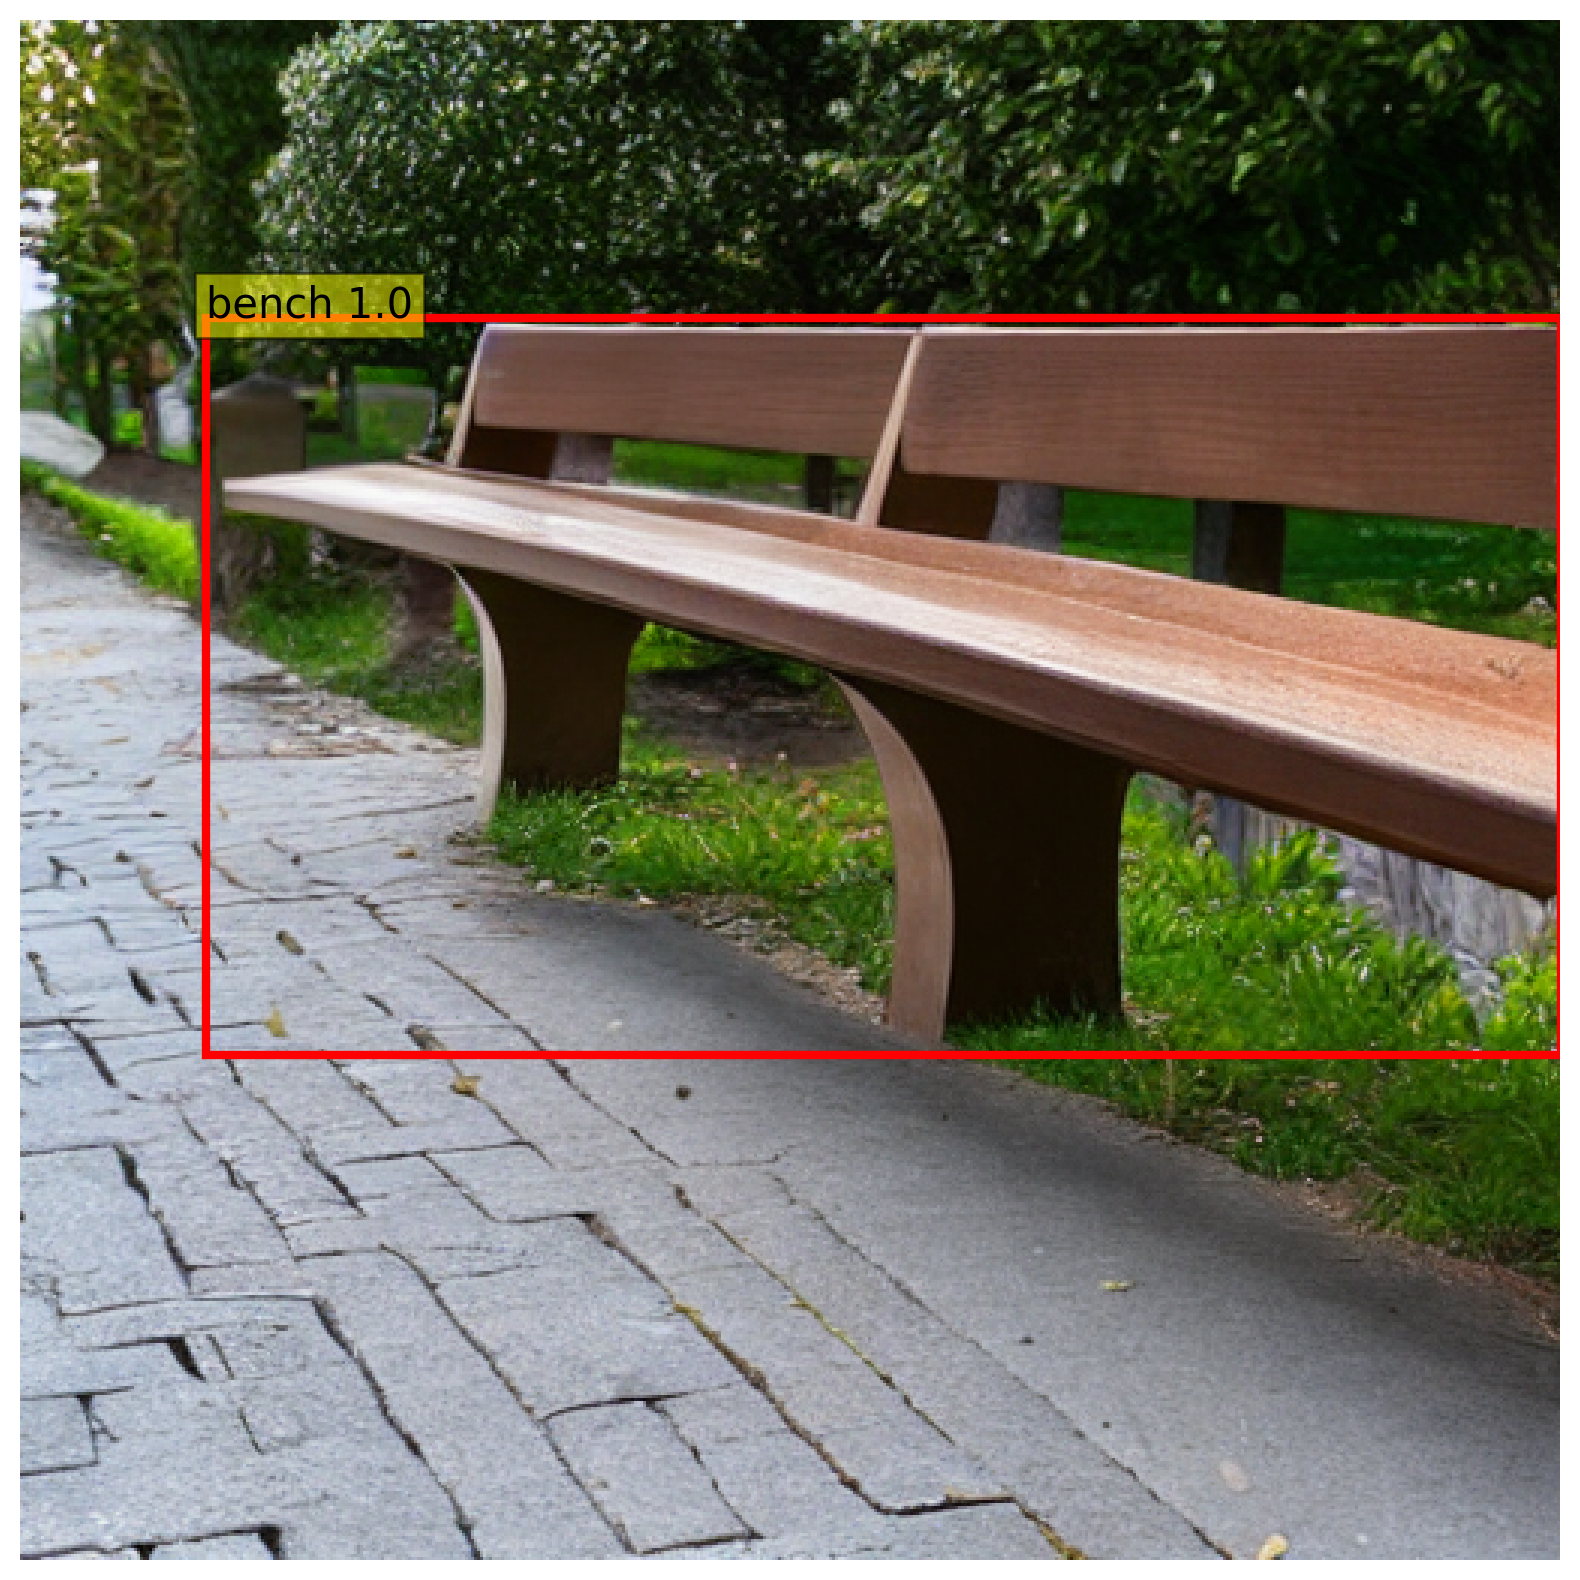

In [19]:
vis = Visualize()
vis.visualize_detr(image, not_pertrubed_scores, not_pertrubed_labels, not_pertrubed_bbox)

# Inference with Attack

In [8]:
from matplotlib import cm
image_grad = pixel_values.grad
image_grad_sign = image_grad.sign()
perturbed_image = pixel_values + 0.003 * image_grad_sign
perturbed_image = torch.clamp(perturbed_image, 0, 1)

inputs_ = processor.preprocess(perturbed_image, return_tensors="pt", do_rescale=False).to(device)
outputs_ = model(**inputs_)

target_sizes = torch.tensor([image.size[::-1]])
results_ = processor.post_process_object_detection(outputs_, threshold=0.9, target_sizes=target_sizes)[
    0
]

for score, label, box in zip(results_["scores"], results_["labels"], results_["boxes"]):
    box = [round(i, 2) for i in box.tolist()]
    print(
        f"Detected {model.config.id2label[label.item()]} with confidence "
        f"{round(score.item(), 3)} at location {box}"
    )
    

Detected boat with confidence 0.991 at location [65.62, 99.3, 511.91, 283.76]


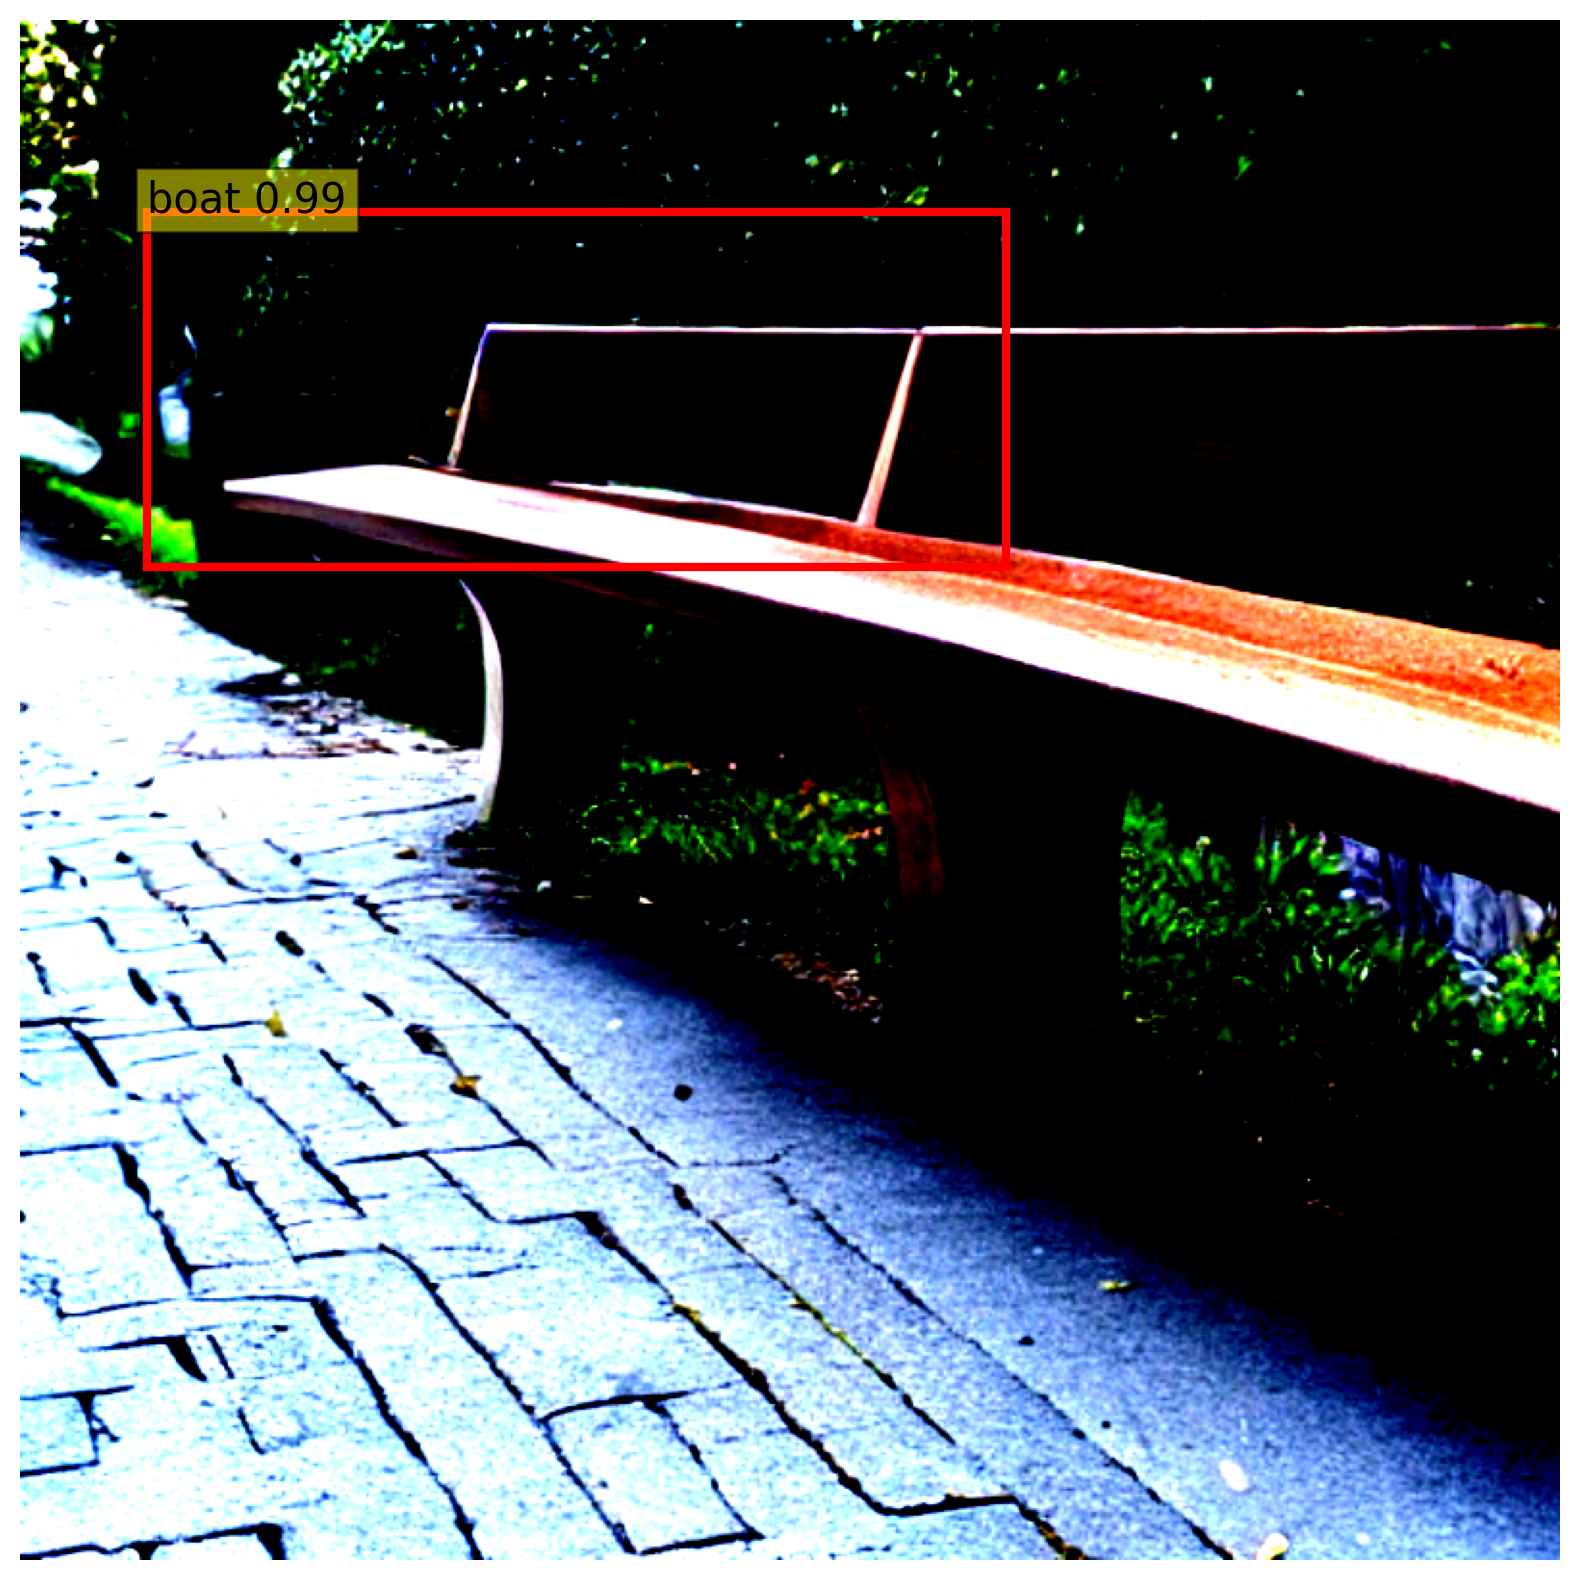

In [10]:
vis = Visualize()

text = model.config.id2label[label.item()]
final_image = perturbed_image.squeeze().permute(1,2,0).detach().cpu().numpy()
final_image_pil = Image.fromarray(np.uint8(final_image*255), mode='RGB')

pred_labels = results_["labels"].tolist()
pred_labels = [model.config.id2label[i] for i in pred_labels]
pred_scores = results_["scores"].tolist()
pred_boxes = results_["boxes"].tolist()

vis.visualize_detr(final_image_pil, pred_scores, pred_labels, pred_boxes )

# Display Attacked Predictions on Original Image

In [12]:
def bbox_scale_to_original(pred_boxes, prediction_size, originial_size):
    """
    Returns bounding box values for original sized image.

    Parameters
    pred_boxes (torch.tensor): Tensor containing bounding box values for each predicted bounding box in the scaled image.
    scaled_size (tuple): Tuple containing scaled image width and height. List of tuples if there is a batch of images.
    original_size (tuple): Tuple containing original image width and height. List of tuples if there is a batch of images.
    """
    pred_boxes = pred_boxes.detach().cpu()
    w_org, h_org = originial_size
    w_scl, h_scl = prediction_size
    orig_bbox = []
    for box in pred_boxes:
        orig_bbox.append(((box / torch.Tensor([w_scl,h_scl, w_scl, h_scl]))  * torch.Tensor([w_org,h_org,w_org,h_org])).tolist())

    return orig_bbox



In [13]:
orig_size = image.size
scaled_size = pixel_values.size()[-2:]
orig_bbox = bbox_scale_to_original(results_["boxes"],scaled_size,orig_size)

pred_labels = results_["labels"].tolist()
pred_labels = [model.config.id2label[i] for i in pred_labels]
pred_scores = results_["scores"].tolist()

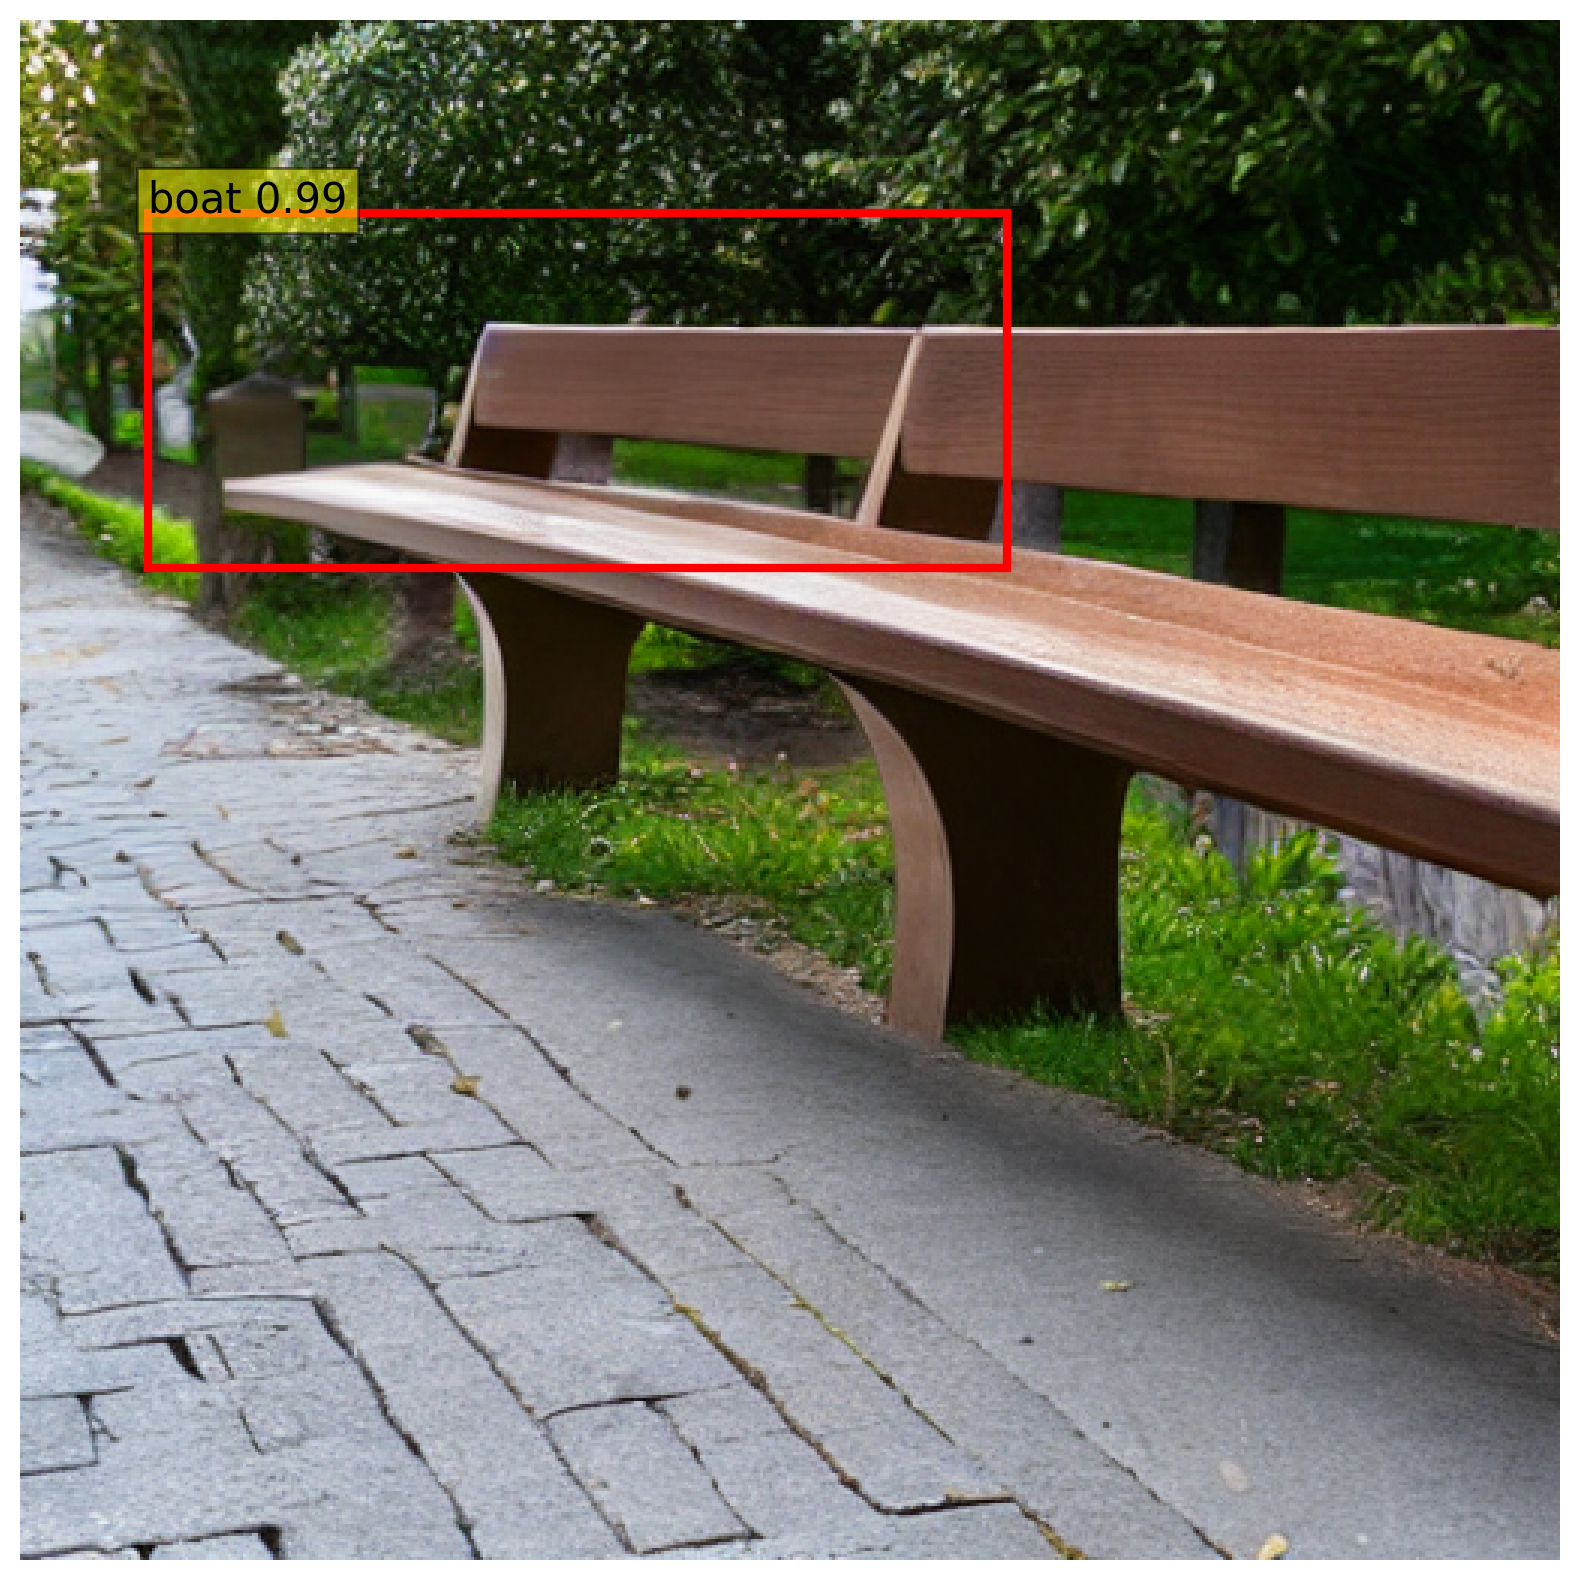

In [20]:
vis = Visualize()
vis.visualize_detr(image, pred_scores, pred_labels, orig_bbox)